In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import umap
from yellowbrick.cluster import SilhouetteVisualizer 
from sklearn.manifold import TSNE
import seaborn as sns

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_shape_z = pd.read_csv(os.path.join(folder_path, "features_shape_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_shape_mm = pd.read_csv(os.path.join(folder_path, "features_shape_minmax.csv"))

In [4]:
df_shape_z

,area,perimeter,eccentricity,extent,solidity,orientation,major_axis_length,minor_axis_length,filename,label
0,-0.961415,-0.894772,1.258475,-0.843346,0.135962,0.447795,-0.597306,-1.185373,callo_1.png,smaller_than
1,-0.360419,0.546777,1.265948,-1.740919,-1.705151,-1.271934,0.510064,-0.369311,callo_10.png,smaller_than
2,-1.007075,-1.161657,0.280864,1.120647,1.269197,1.018866,-1.051417,-1.039241,callo_100.png,smaller_than
3,-0.791399,-0.944172,0.602786,1.184475,0.913221,-0.441900,-0.690335,-0.847833,callo_101.png,smaller_than
4,-1.449934,-1.612899,-0.817832,1.002834,1.210664,0.876506,-1.792010,-1.527979,callo_102.png,smaller_than
...,...,...,...,...,...,...,...,...,...,...
532,0.677867,1.059505,-0.758095,-0.543333,-0.607485,-0.690380,0.538420,1.134106,callo_95.png,higher_than
533,1.092142,0.926063,-1.279988,0.358045,0.055104,-1.057077,0.529269,1.361404,callo_96.png,higher_than
534,0.792944,0.682934,0.155389,-0.292736,-0.289068,-0.225443,0.734055,0.798670,callo_97.png,higher_than
535,0.594344,1.013475,-0.407132,-1.763399,-1.467330,1.445790,0.819826,1.257650,callo_98.png,higher_than


In [5]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_z_cl= df_shape_z.drop(columns=['filename', 'label'])

Se realiza clustering con k-means. Para averiguar cual va a ser el mejor valor de k o clusters se aplica el método
del "codo". También se simularán con diferentes números de clusteres la silueta.

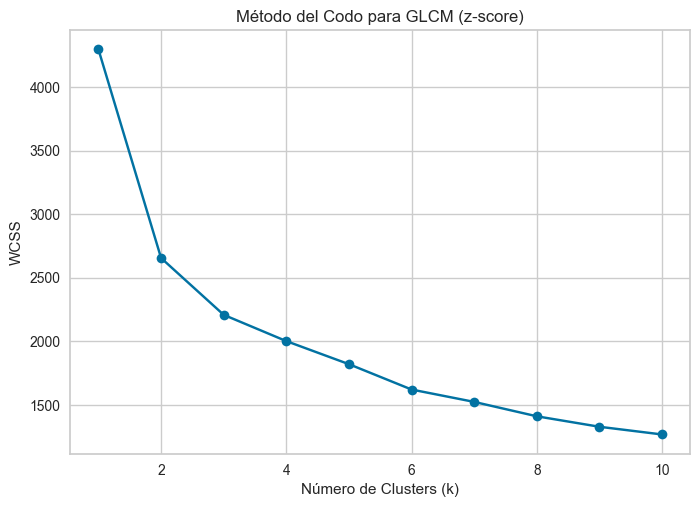

In [6]:
# Método del codo
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, random_state=42)
    kmeans.fit(df_shape_z_cl)
    WCSS.append(kmeans.inertia_)

# Graficar el codo
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.title('Método del Codo para GLCM (z-score)')
plt.grid(True)
plt.show()

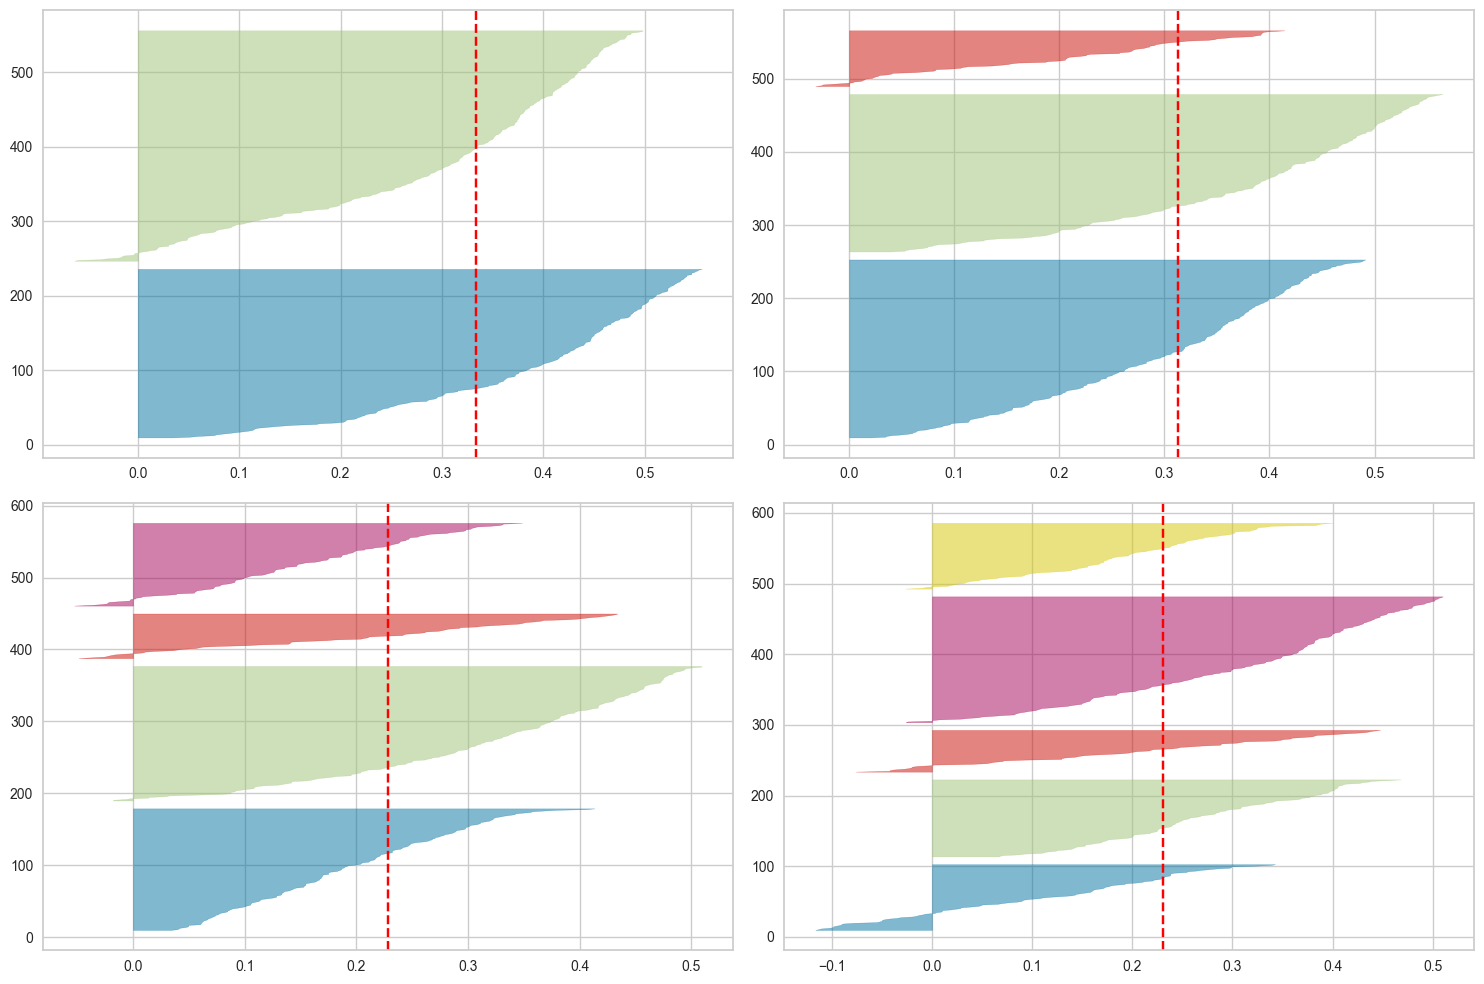

In [7]:
# Creamos la figura con 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probamos con k = 2, 3, 4, 5
for i, k in enumerate([2, 3, 4, 5]):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    
    # Posición del subplot
    row = i // 2
    col = i % 2
    
    # Creamos el visualizador y ajustamos los datos
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[row][col])
    visualizer.fit(df_shape_z_cl)  

plt.tight_layout()
plt.show()

Como se obtiene mejor silueta con 2 clusteres se establecerán 2 clusteres en n_clusters.

In [8]:
#Modelo k-means
cluster_shape_z= KMeans(init='k-means++',n_clusters=2,random_state=42)
cluster_shape_z.fit(df_shape_z_cl)   

KMeans(n_clusters=2, random_state=42)

In [9]:
#Se añaden las etiquetas y vemos en una tabla de contigencia cuantos smaller o higher hay en cada cluster
df_shape_z['Cluster'] = cluster_shape_z.labels_
pd.crosstab(df_shape_z['Cluster'], df_shape_z['label'])

label,higher_than,smaller_than
Cluster,,
0,18,216
1,250,53


In [10]:
silhouette_avg_shape_z = silhouette_score(df_shape_z_cl, cluster_shape_z.labels_)
print(f'Índice de silueta promedio: {silhouette_avg_shape_z}')

Índice de silueta promedio: 0.333307961684949


El 80,29% de imagenes SMALLER estarán en el cluster 0, y el 93,28% de las imágenes HIGHER estan en el cluster 1. 
Esto nos quiere decir que hay dos clusteres bien diferenciados, sin embargo, el índice silueta de 0.333. Esto nos quiere
decir que aunque hay separación entre clases según características de forma, los puntos dentro de cada cluster puedene star
separados y además hay cercanía al otro clster.

Se realiza una visualización de los clusteres con t-sne y umap, para reducir la dimensionalidad y poder ver las estructuras mejor.

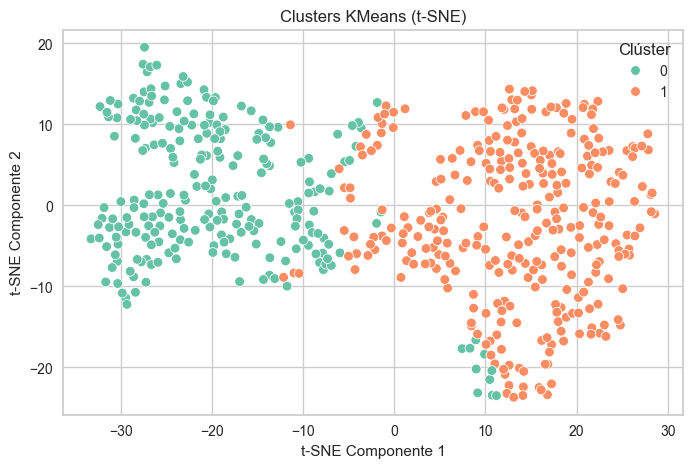

In [11]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_shape_z_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_shape_z['Cluster'], palette='Set2')
plt.title('Clusters KMeans (t-SNE)')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


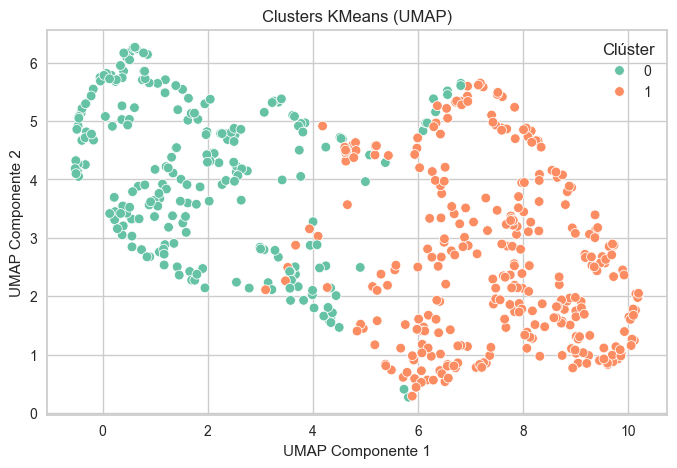

In [12]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_shape_z_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_shape_z['Cluster'], palette='Set2')
plt.title('Clusters KMeans (UMAP)')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

Ahora se realiza lo mismo pero con la normalización min-max

In [13]:
df_shape_mm

,area,perimeter,eccentricity,extent,solidity,orientation,major_axis_length,minor_axis_length,filename,label
0,0.164032,0.204438,0.840083,0.448592,0.749355,0.638915,0.358292,0.192486,callo_1.png,smaller_than
1,0.297348,0.477599,0.841452,0.301952,0.441238,0.138360,0.592452,0.362256,callo_10.png,smaller_than
2,0.153903,0.153865,0.660993,0.769458,0.939005,0.805135,0.262267,0.222887,callo_100.png,smaller_than
3,0.201746,0.195077,0.719967,0.779886,0.879431,0.379955,0.338620,0.262706,callo_101.png,smaller_than
4,0.055665,0.068359,0.459722,0.750210,0.929210,0.763699,0.105664,0.121212,callo_102.png,smaller_than
...,...,...,...,...,...,...,...,...,...,...
532,0.527668,0.574757,0.470665,0.497607,0.624936,0.307631,0.598448,0.675020,callo_95.png,higher_than
533,0.619565,0.549471,0.375058,0.644869,0.735823,0.200897,0.596513,0.722306,callo_96.png,higher_than
534,0.553195,0.503400,0.638007,0.538548,0.678224,0.442958,0.639816,0.605237,callo_97.png,higher_than
535,0.509140,0.566035,0.534958,0.298279,0.481038,0.929398,0.657953,0.700721,callo_98.png,higher_than


In [14]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_mm_cl= df_shape_mm.drop(columns=['filename', 'label'])

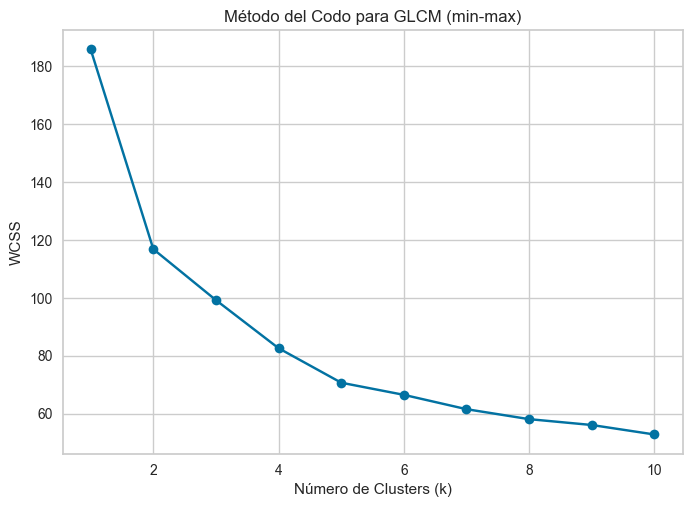

In [15]:
# Método del codo
WCSS = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, random_state=42)
    kmeans.fit(df_shape_mm_cl)
    WCSS.append(kmeans.inertia_)

# Graficar el codo
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.title('Método del Codo para GLCM (min-max)')
plt.grid(True)
plt.show()

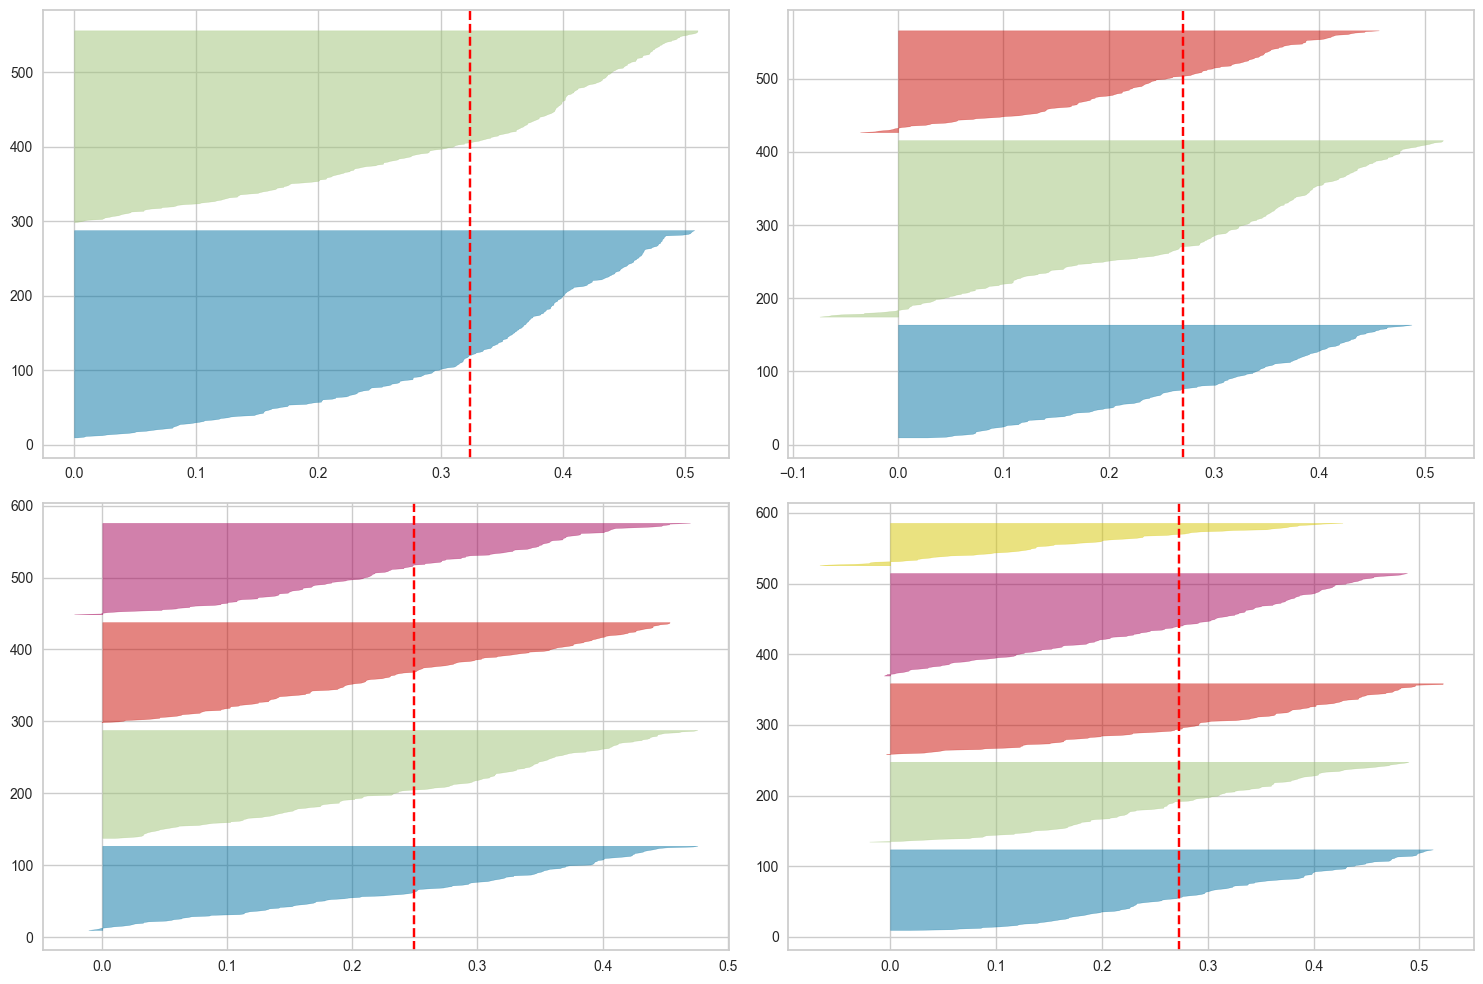

In [16]:
# Creamos la figura con 2x2 subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probamos con k = 2, 3, 4, 5
for i, k in enumerate([2, 3, 4, 5]):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    
    # Posición del subplot
    row = i // 2
    col = i % 2
    
    # Creamos el visualizador y ajustamos los datos
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[row][col])
    visualizer.fit(df_shape_mm_cl)  # Usa tu dataframe ya escalado o transformado

plt.tight_layout()
plt.show()

In [17]:
#Modelo k-means
cluster_shape_mm= KMeans(init='k-means++',n_clusters=2,random_state=42)
cluster_shape_mm.fit(df_shape_mm_cl) 

KMeans(n_clusters=2, random_state=42)

In [18]:
#Se añaden las etiquetas y vemos en una tabla de contigencia cuantos smaller o higher hay en cada cluster
df_shape_mm['Cluster'] = cluster_shape_mm.labels_
pd.crosstab(df_shape_mm['Cluster'], df_shape_mm['label'])

label,higher_than,smaller_than
Cluster,,
0,26,235
1,242,34


In [19]:
silhouette_avg_shape_mm = silhouette_score(df_shape_mm_cl, cluster_shape_mm.labels_)
print(f'Índice de silueta promedio: {silhouette_avg_shape_mm}')

Índice de silueta promedio: 0.32387716374680503


Pasa lo mismo que con la normalización z-score. En el cluster 0 encontramos el 87.36% de las imagenes etiquetadas como SMALLER, y en el cluster 1, el 90.29% de las imágenes
etiquetadas como HIGHER, pero la silueya no es buena.

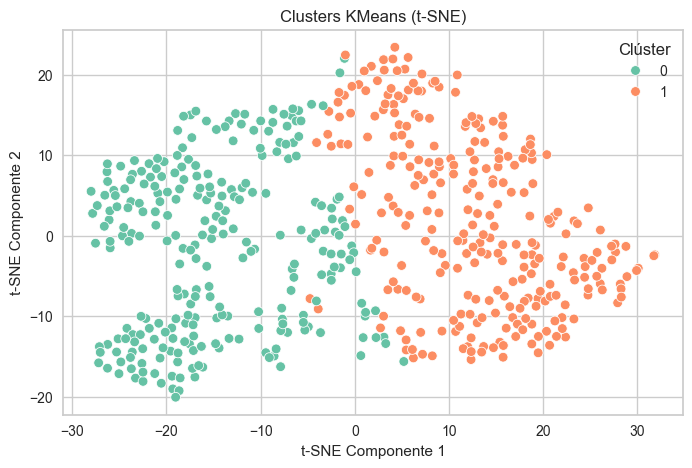

In [20]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_shape_mm_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_shape_mm['Cluster'], palette='Set2')
plt.title('Clusters KMeans (t-SNE)')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


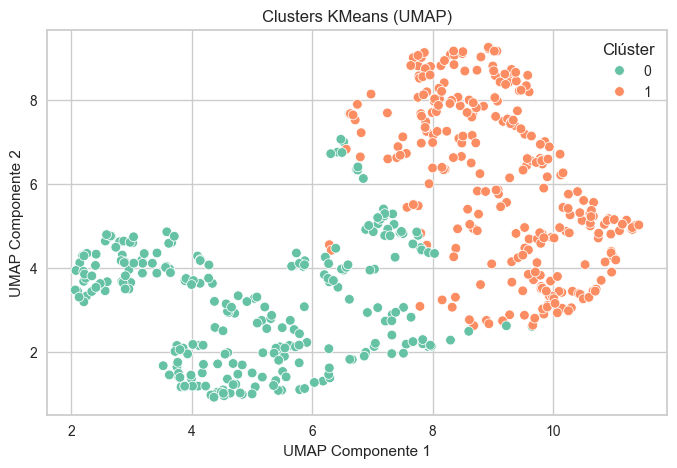

In [21]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_shape_mm_cl)

# Visualización
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=df_shape_mm['Cluster'], palette='Set2')
plt.title('Clusters KMeans (UMAP)')
plt.xlabel('UMAP Componente 1')
plt.ylabel('UMAP Componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

Para poder hacer una visualización con más calidad de los clusteres se aplica UMAP para hacer una reducción de la dimensionalidad
y luego sobre los datos obtenidos se realiza de nuevo el clustering k-means.

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


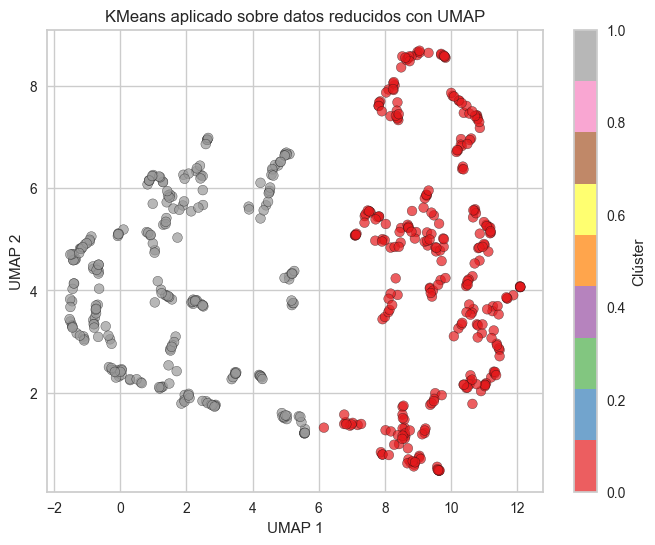

Índice de silueta (UMAP + KMeans): 0.568


In [28]:
# 1. Reducción de dimensionalidad con UMAP
umap_model = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.01, random_state=42)
X_umap = umap_model.fit_transform(df_shape_z_cl)

# 2. Aplicar KMeans sobre el espacio reducido
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_umap)

# 3. Añadir los clústeres al dataframe original
df_shape_z['Cluster_UMAP'] = clusters

# 4. Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=clusters, cmap='Set1', edgecolor='k', alpha=0.7
)
plt.title('KMeans aplicado sobre datos reducidos con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

# 5. Índice de silueta
silhouette = silhouette_score(X_umap, clusters)
print(f"Índice de silueta (UMAP + KMeans): {silhouette:.3f}")

In [29]:
pd.crosstab(df_shape_z['label'], df_shape_z['Cluster_UMAP'])

Cluster_UMAP,0,1
label,,
higher_than,239,29
smaller_than,50,219


minmax:

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


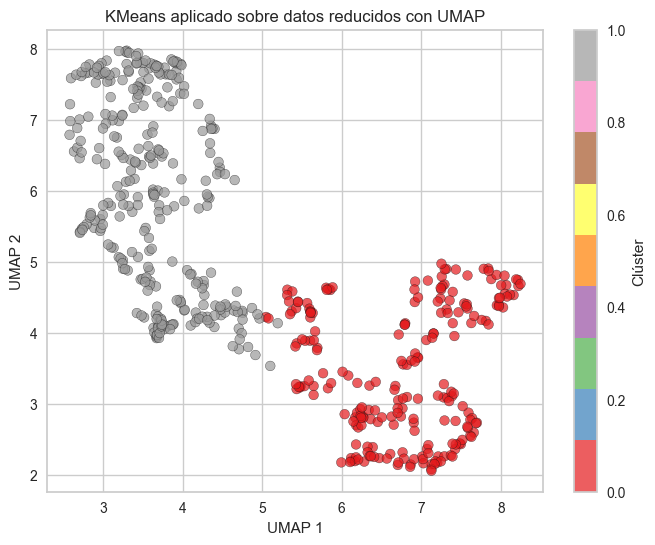

Índice de silueta (UMAP + KMeans): 0.525


In [39]:
# 1. Reducción de dimensionalidad con UMAP
umap_model_mm = umap.UMAP(n_neighbors=13, n_components=5, min_dist=0.01, random_state=42)
X_umap_mm = umap_model_mm.fit_transform(df_shape_mm_cl)

# 2. Aplicar KMeans sobre el espacio reducido
kmeans_mm = KMeans(n_clusters=2, init='k-means++', random_state=42)
clusters_mm = kmeans_mm.fit_predict(X_umap_mm)

# 3. Añadir los clústeres al dataframe original
df_shape_mm['Cluster_UMAP'] = clusters_mm

# 4. Visualizar los resultados
plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap_mm[:, 0], X_umap_mm[:, 1],
    c=clusters_mm, cmap='Set1', edgecolor='k', alpha=0.7
)
plt.title('KMeans aplicado sobre datos reducidos con UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

# 5. Índice de silueta
silhouette_mm = silhouette_score(X_umap_mm, clusters_mm)
print(f"Índice de silueta (UMAP + KMeans): {silhouette_mm:.3f}")

In [40]:
pd.crosstab(df_shape_mm['label'], df_shape_mm['Cluster_UMAP'])

Cluster_UMAP,0,1
label,,
higher_than,18,250
smaller_than,205,64
